In [1]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np
import fiona
import seaborn as sns  
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


from matplotlib import colors

from pysal.lib  import weights
from esda.moran import Moran, Moran_Local

from splot.esda import moran_scatterplot,lisa_cluster, plot_local_autocorrelation

# 데이터 통합

## 인구정보 + 건물연면적

## 3+4+5+6+10 merge

In [2]:
df3 = gpd.read_file('input/3.용인시_인구정보(총인구수)_격자.geojson')
df3.loc[df3['val'].apply(pd.isna), 'val'] = 0
df3.columns=['gid','총인구수','geometry']
df4=gpd.read_file('input/4.용인시_인구정보(고령)_격자.geojson')
df4.loc[df4['val'].apply(pd.isna), 'val'] = 0
df4.columns=['gid','고령인구수','geometry']
df5= gpd.read_file('input/5.용인시_인구정보(생산가능)_격자.geojson')
df5.loc[df5['val'].apply(pd.isna), 'val'] = 0
df5.columns=['gid','생산가능인구수','geometry']
df6= gpd.read_file('input/6.용인시_인구정보(유소년)_격자.geojson')
df6.loc[df6['val'].apply(pd.isna), 'val'] = 0
df6.columns=['gid','유소년인구수','geometry']
df_p=df3.merge(df4, on='gid')
df_p=df_p.merge(df5,on='gid')
df_p=df_p.merge(df6,on='gid')
del df_p["geometry_y"]
df_p.columns=['gid','all_cnt','geometry','old_cnt','adult_cnt','geo','young_cnt']
del df_p["geo"]
df_p.head()

,gid,all_cnt,geometry,old_cnt,adult_cnt,young_cnt
0,다바661999,0.0,"MULTIPOLYGON (((127.11851 37.09713, 127.11851 ...",0.0,0.0,0.0
1,다바662996,0.0,"MULTIPOLYGON (((127.11965 37.09443, 127.11965 ...",0.0,0.0,0.0
2,다바662997,0.0,"MULTIPOLYGON (((127.11965 37.09533, 127.11964 ...",0.0,0.0,0.0
3,다바662998,0.0,"MULTIPOLYGON (((127.11964 37.09623, 127.11964 ...",0.0,0.0,0.0
4,다바662999,0.0,"MULTIPOLYGON (((127.11964 37.09713, 127.11963 ...",0.0,0.0,0.0


In [3]:
df10= gpd.read_file('input/10.용인시_건물연면적_격자.geojson')
df10.loc[df10['val'].apply(pd.isna), 'val'] = 0
df10.columns=['gid','건물연면적','geometry']
df_p=df_p.merge(df10,on='gid')
del df_p['geometry_y']
df_p.columns=['gid','all_cnt','geometry','old_cnt','adult_cnt','young_cnt','건물연면적']
df_p.head()#df_p는 3456 +10 병합

,gid,all_cnt,geometry,old_cnt,adult_cnt,young_cnt,건물연면적
0,다바661999,0.0,"MULTIPOLYGON (((127.11851 37.09713, 127.11851 ...",0.0,0.0,0.0,0.0
1,다바662996,0.0,"MULTIPOLYGON (((127.11965 37.09443, 127.11965 ...",0.0,0.0,0.0,0.0
2,다바662997,0.0,"MULTIPOLYGON (((127.11965 37.09533, 127.11964 ...",0.0,0.0,0.0,0.0
3,다바662998,0.0,"MULTIPOLYGON (((127.11964 37.09623, 127.11964 ...",0.0,0.0,0.0,0.0
4,다바662999,0.0,"MULTIPOLYGON (((127.11964 37.09713, 127.11963 ...",0.0,0.0,0.0,0.0


## 500 격자로 통합한 인구+건물연면적

In [4]:
grid100 = pd.read_csv('./input/grid100to500.csv')
temp = pd.merge(df_p,grid100,left_on='gid',right_on='gid100')
fin_df_p = temp.groupby('gid500').sum().reset_index()
fin_df_p

,gid500,all_cnt,old_cnt,adult_cnt,young_cnt,건물연면적
0,다바66a99a,0.0,0.0,0.0,0.0,0.00
1,다바66a99b,0.0,0.0,0.0,0.0,0.00
2,다바66b99a,88.0,13.0,56.0,0.0,1781.97
3,다바66b99b,0.0,0.0,0.0,0.0,182.80
4,다바67a99a,0.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...
2585,다사93a04b,0.0,0.0,0.0,0.0,0.00
2586,다사93a05a,0.0,0.0,0.0,0.0,0.00
2587,다사93a05b,0.0,0.0,0.0,0.0,0.00
2588,다사93b05a,0.0,0.0,0.0,0.0,0.00


## 소상공인 매출

In [5]:
df16 = gpd.read_file('input/16.용인시_소상공인_매출정보.geojson')
df17 = pd.read_csv('input/17.용인시_소상공인_매출정보.csv')

In [6]:
df16.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 9915 entries, 0 to 9914
Data columns (total 67 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   gid                     9915 non-null   object  
 1   ws_cnt                  807 non-null    float64 
 2   found_age_1             807 non-null    float64 
 3   found_age_2             807 non-null    float64 
 4   found_age_3             807 non-null    float64 
 5   found_age_4             807 non-null    float64 
 6   found_age_5             807 non-null    float64 
 7   found_age_6             807 non-null    float64 
 8   runout_cnt              807 non-null    float64 
 9   smbiz_yn_cnt            807 non-null    float64 
 10  rpr_per_gender_m        807 non-null    float64 
 11  rpr_per_gender_f        807 non-null    float64 
 12  rpr_per_age_bin_10      807 non-null    float64 
 13  rpr_per_age_bin_20      807 non-null    float64 
 14  rpr_per_age_bin_

## 500 격자로 통합한 매출 데이터

In [7]:
grid250 = pd.read_csv('./input/grid250to500.csv')
temp2 = pd.merge(df16,grid250,left_on='gid',right_on='gid250')
temp2
fin_df_p2 = temp2.groupby('gid500').sum().reset_index()
fin_df_p2

,gid500,ws_cnt,found_age_1,found_age_2,found_age_3,found_age_4,found_age_5,found_age_6,runout_cnt,smbiz_yn_cnt,...,sales_est_amt_202003,sales_est_amt_202006,sales_est_amt_202009,age10_ratio,age20_ratio,age30_ratio,age40_ratio,age50_ratio,age60_ratio,age70_ratio
0,다바66a99a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,다바66a99b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,다바66b99a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,다바66b99b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,다바67a99a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2585,다사93a04b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2586,다사93a05a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2587,다사93a05b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2588,다사93b05a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 독립변수

In [8]:
df_val = pd.read_csv('./input/대격자별_독립변수.csv')
df_geo = gpd.read_file('./input/500grid.shp')
df_geo = df_geo[['gid','geometry']]
df_geo.columns = ['gid500','geometry']
temp3 = pd.merge(fin_df_p,fin_df_p2,on='gid500')
temp3 = pd.merge(temp3,df_val,on='gid500')
fin_df = pd.merge(temp3,df_geo,on='gid500')
fin_df.head()

,gid500,all_cnt,old_cnt,adult_cnt,young_cnt,건물연면적,ws_cnt,found_age_1,found_age_2,found_age_3,...,cnt_busstop,cnt_subway,cnt_clinic,cnt_hospital,cnt_element_s,cnt_middles_s,cnt_high_s,cnt_university,cnt_landmark,geometry
0,다바66a99a,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((127.11743 37.08901, 127.11741 37.093..."
1,다바66a99b,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,"POLYGON ((127.11741 37.09352, 127.11738 37.098..."
2,다바66b99a,88.0,13.0,56.0,0.0,1781.97,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,"POLYGON ((127.12306 37.08903, 127.12303 37.093..."
3,다바66b99b,0.0,0.0,0.0,0.0,182.80,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((127.12303 37.09353, 127.12301 37.098..."
4,다바67a99a,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((127.12868 37.08905, 127.12866 37.093..."


## 구-동-지번 지역데이터 통합

In [9]:
df11=gpd.read_file('input/11.용인시_법정경계(시군구).geojson')
df12=gpd.read_file('input/12.용인시_법정경계(읍면동).geojson')
df12['SIG_CD']= df12['EMD_CD'].str.slice(start=0, stop=5)
df_cd=df12.merge(df11, on='SIG_CD')
df_cd.columns=['EMD_CD','EMD_KOR_NM','geometry_12','SIG_CD','SIG_KOR_NM','geometry_11']

df14=gpd.read_file('input/14.용인시_지적도.geojson')
df14['SIG_CD']= df14['PNU'].str.slice(start=0, stop=5)

df_cd=df_cd.merge(df14, on='SIG_CD')
df_cd.head()

,EMD_CD,EMD_KOR_NM,geometry_12,SIG_CD,SIG_KOR_NM,geometry_11,PNU,JIBUN,geometry
0,41461101,김량장동,"MULTIPOLYGON (((127.19037 37.23145, 127.19042 ...",41461,용인시처인구,"MULTIPOLYGON (((127.10873 37.12385, 127.10874 ...",4146110100103160004,316-4대,"MULTIPOLYGON (((127.20036 37.23654, 127.20053 ..."
1,41461101,김량장동,"MULTIPOLYGON (((127.19037 37.23145, 127.19042 ...",41461,용인시처인구,"MULTIPOLYGON (((127.10873 37.12385, 127.10874 ...",4146110100103160003,316-3대,"MULTIPOLYGON (((127.20005 37.23660, 127.20036 ..."
2,41461101,김량장동,"MULTIPOLYGON (((127.19037 37.23145, 127.19042 ...",41461,용인시처인구,"MULTIPOLYGON (((127.10873 37.12385, 127.10874 ...",4146110100105070002,507-2도,"MULTIPOLYGON (((127.19789 37.23145, 127.19786 ..."
3,41461101,김량장동,"MULTIPOLYGON (((127.19037 37.23145, 127.19042 ...",41461,용인시처인구,"MULTIPOLYGON (((127.10873 37.12385, 127.10874 ...",4146110100103580002,358-2도,"MULTIPOLYGON (((127.19784 37.23123, 127.19785 ..."
4,41461101,김량장동,"MULTIPOLYGON (((127.19037 37.23145, 127.19042 ...",41461,용인시처인구,"MULTIPOLYGON (((127.10873 37.12385, 127.10874 ...",4146110100103590005,359-5대,"MULTIPOLYGON (((127.19785 37.23145, 127.19765 ..."


## 지역별 merge 최종: df_cd

In [14]:
df_cd.columns=['EMD_CD','EMD_KOR_NM','geometry_12','SIG_CD','SIG_KOR_NM','geometry_11','PNU','JIBUN','geometry_14']
df_cd.head()

,EMD_CD,EMD_KOR_NM,geometry_12,SIG_CD,SIG_KOR_NM,geometry_11,PNU,JIBUN,geometry_14
0,41461101,김량장동,"MULTIPOLYGON (((127.19037 37.23145, 127.19042 ...",41461,용인시처인구,"MULTIPOLYGON (((127.10873 37.12385, 127.10874 ...",4146110100103160004,316-4대,"MULTIPOLYGON (((127.20036 37.23654, 127.20053 ..."
1,41461101,김량장동,"MULTIPOLYGON (((127.19037 37.23145, 127.19042 ...",41461,용인시처인구,"MULTIPOLYGON (((127.10873 37.12385, 127.10874 ...",4146110100103160003,316-3대,"MULTIPOLYGON (((127.20005 37.23660, 127.20036 ..."
2,41461101,김량장동,"MULTIPOLYGON (((127.19037 37.23145, 127.19042 ...",41461,용인시처인구,"MULTIPOLYGON (((127.10873 37.12385, 127.10874 ...",4146110100105070002,507-2도,"MULTIPOLYGON (((127.19789 37.23145, 127.19786 ..."
3,41461101,김량장동,"MULTIPOLYGON (((127.19037 37.23145, 127.19042 ...",41461,용인시처인구,"MULTIPOLYGON (((127.10873 37.12385, 127.10874 ...",4146110100103580002,358-2도,"MULTIPOLYGON (((127.19784 37.23123, 127.19785 ..."
4,41461101,김량장동,"MULTIPOLYGON (((127.19037 37.23145, 127.19042 ...",41461,용인시처인구,"MULTIPOLYGON (((127.10873 37.12385, 127.10874 ...",4146110100103590005,359-5대,"MULTIPOLYGON (((127.19785 37.23145, 127.19765 ..."


In [15]:
dfmerge12=pd.read_csv('./input/1_2.용인시_상권_정보_결합_결측치처리.csv')
df12['SIG_CD']= df12['EMD_CD'].str.slice(start=0, stop=5)
df_dong=df12.merge(df11, on='SIG_CD')
df_dong.columns=['EMD_CD','EMD_KOR_NM','geometry_12','SIG_CD','SIG_KOR_NM','geometry_11']

dfmerge12['동이름']= dfmerge12['행정동명'].str.slice(start=0, stop=2)
df_dong['동이름']= df_dong['EMD_KOR_NM'].str.slice(start=0, stop=2)
df_market_dong=dfmerge12.merge(df_dong, on='동이름')

## 1+2+11+12 통합 : df_market_dong

In [16]:
df_market_dong.head()

,Unnamed: 0,대분류코드,중분류코드,소분류코드,표준산업분류코드,표준산업분류명,행정동코드,행정동명,도로명주소,경도,...,대분류명,중분류명,소분류명,동이름,EMD_CD,EMD_KOR_NM,geometry_12,SIG_CD,SIG_KOR_NM,geometry_11
0,0,Q,Q09,Q09A10,I56211,일반유흥 주점업,4146551000,풍덕천1동,경기도 용인시 수지구 풍덕천로139번길 6-5,127.096851,...,음식,유흥주점,룸살롱/단란주점,풍덕,41465101,풍덕천동,"MULTIPOLYGON (((127.07961 37.31468, 127.07964 ...",41465,용인시수지구,"MULTIPOLYGON (((127.02966 37.37213, 127.02975 ..."
1,1,Q,Q01,Q01A08,I56111,한식 음식점업,4146551000,풍덕천1동,경기도 용인시 수지구 풍덕천로190번길 23,127.102347,...,음식,한식,족발/보쌈전문,풍덕,41465101,풍덕천동,"MULTIPOLYGON (((127.07961 37.31468, 127.07964 ...",41465,용인시수지구,"MULTIPOLYGON (((127.02966 37.37213, 127.02975 ..."
2,17,F,F09,F09A03,S96121,욕탕업,4146551000,풍덕천1동,경기도 용인시 수지구 풍덕천로 155,127.098033,...,생활서비스,대중목욕탕/휴게,목욕업-찜질방,풍덕,41465101,풍덕천동,"MULTIPOLYGON (((127.07961 37.31468, 127.07964 ...",41465,용인시수지구,"MULTIPOLYGON (((127.02966 37.37213, 127.02975 ..."
3,22,D,D23,D23A06,G45219,기타 자동차신품 부품 및 내장품 판매업,4146551000,풍덕천1동,경기도 용인시 수지구 풍덕천로197번길 3-17,127.101804,...,소매,자동차/자동차용품,자동차부품판매,풍덕,41465101,풍덕천동,"MULTIPOLYGON (((127.07961 37.31468, 127.07964 ...",41465,용인시수지구,"MULTIPOLYGON (((127.02966 37.37213, 127.02975 ..."
4,23,F,F03,F03A07,S95121,컴퓨터 및 사무용 기기 수리업,4146551000,풍덕천1동,경기도 용인시 수지구 수풍로 9,127.089558,...,생활서비스,개인/가정용품수리,컴퓨터수리,풍덕,41465101,풍덕천동,"MULTIPOLYGON (((127.07961 37.31468, 127.07964 ...",41465,용인시수지구,"MULTIPOLYGON (((127.02966 37.37213, 127.02975 ..."


# 회귀분석 사용할 데이터:fin_df

In [18]:
fin_df.columns

Index(['gid500', 'all_cnt', 'old_cnt', 'adult_cnt', 'young_cnt', '건물연면적',
       'ws_cnt', 'found_age_1', 'found_age_2', 'found_age_3', 'found_age_4',
       'found_age_5', 'found_age_6', 'runout_cnt', 'smbiz_yn_cnt',
       'rpr_per_gender_m', 'rpr_per_gender_f', 'rpr_per_age_bin_10',
       'rpr_per_age_bin_20', 'rpr_per_age_bin_30to50',
       'rpr_per_age_bin_50over', 'sme_loan_cnt', 'sme_loan_y_1',
       'sme_loan_y_2', 'sme_loan_y_3', 'sme_loan_y_4', 'sme_loan_y_5',
       'sme_loan_y_6', 'sales_est_amt_201703', 'sales_est_amt_201706',
       'sales_est_amt_201709', 'sales_est_amt_201712', 'sales_est_amt_201803',
       'sales_est_amt_201806', 'sales_est_amt_201809', 'sales_est_amt_201812',
       'sales_est_amt_201903', 'sales_est_amt_201906', 'sales_est_amt_201909',
       'sales_est_amt_201912', 'sales_est_amt_202003', 'sales_est_amt_202006',
       'sales_est_amt_202009', 'age10_ratio', 'age20_ratio', 'age30_ratio',
       'age40_ratio', 'age50_ratio', 'age60_ratio', 'age70_

독립변수 선정 :
1. 지하철 역, 버스 정류장, 도로폭 -> 교통 접근성 : 'cnt_busstop', 'cnt_subway' -->합해서 하나의 변수로 만들어준다: traffic
2. 초중고, 대학교 -> 교육 'cnt_element_s', 'cnt_middles_s', 'cnt_high_s', 'cnt_university' -->합:schools 
3. 병원 -> 의료 :'cnt_clinic', 'cnt_hospital' -->합:medical
4. 랜드마크 -> 문화 :'cnt_landmark' --> landmark
5. 인구 밀도 -> all_cnt	old_cnt	adult_cnt	young_cnt --> all_cnt만 사용(태블로 인구지도로 근거) : population
6. 사업체 수:'ws_cnt' 'cnt_market'-->합: store  (아래 상관계수 근거)

In [19]:
fin_df['traffic']=fin_df['cnt_busstop']+fin_df['cnt_subway']
fin_df['schools']=fin_df['cnt_element_s']+fin_df['cnt_middles_s']+fin_df['cnt_high_s']+fin_df['cnt_university']
fin_df['medical']=fin_df['cnt_clinic']+fin_df['cnt_hospital']
fin_df['landmark']=fin_df['cnt_landmark']
fin_df['population']=fin_df['all_cnt']
fin_df['store']=fin_df['ws_cnt']+fin_df['cnt_market']

In [20]:
fin_df['y_매출액평균']=fin_df['sales_est_amt_201703']+fin_df['sales_est_amt_201706']+fin_df['sales_est_amt_201709']+fin_df['sales_est_amt_201712']+fin_df['sales_est_amt_201803']+fin_df['sales_est_amt_201806']+fin_df['sales_est_amt_201809']+fin_df['sales_est_amt_201812']+fin_df['sales_est_amt_201903']+fin_df['sales_est_amt_201906']+fin_df['sales_est_amt_201909']+fin_df['sales_est_amt_201912']+fin_df['sales_est_amt_202003']+fin_df['sales_est_amt_202006']+fin_df['sales_est_amt_202009']
fin_df['y_매출액평균']=fin_df['y_매출액평균']/15

In [21]:
fin_df['y_분기별매출액평균_03']=(fin_df['sales_est_amt_201703']+fin_df['sales_est_amt_201803']+fin_df['sales_est_amt_201903']+fin_df['sales_est_amt_202003'])/4
fin_df['y_분기별매출액평균_06']=(fin_df['sales_est_amt_201706']+fin_df['sales_est_amt_201806']+fin_df['sales_est_amt_201906']+fin_df['sales_est_amt_202006'])/4
fin_df['y_분기별매출액평균_09']=(fin_df['sales_est_amt_201709']+fin_df['sales_est_amt_201809']+fin_df['sales_est_amt_201909']+fin_df['sales_est_amt_202009'])/4
fin_df['y_분기별매출액평균_12']=(fin_df['sales_est_amt_201712']+fin_df['sales_est_amt_201812']+fin_df['sales_est_amt_201912'])/3

In [22]:
fin_df['y_연도별매출액평균_17']=(fin_df['sales_est_amt_201703']+fin_df['sales_est_amt_201706']+fin_df['sales_est_amt_201709']+fin_df['sales_est_amt_201712'])/4
fin_df['y_연도별매출액평균_18']=(fin_df['sales_est_amt_201803']+fin_df['sales_est_amt_201806']+fin_df['sales_est_amt_201809']+fin_df['sales_est_amt_201812'])/4
fin_df['y_연도별매출액평균_19']=(fin_df['sales_est_amt_201903']+fin_df['sales_est_amt_201906']+fin_df['sales_est_amt_201909']+fin_df['sales_est_amt_201912'])/4
fin_df['y_연도별매출액평균_20']=(fin_df['sales_est_amt_202003']+fin_df['sales_est_amt_202006']+fin_df['sales_est_amt_202009'])/3

In [23]:
print(np.mean(fin_df['ws_cnt']/fin_df['cnt_market']),np.mean(fin_df['ws_cnt']),np.mean(fin_df['cnt_market']))

0.2310768348515272 8.026254826254826 15.406563706563707


In [24]:
fin_df[['ws_cnt','cnt_market']].corr()#상관계수 0.94니까 합으로 하나의 변수로 사용

,ws_cnt,cnt_market
ws_cnt,1.000000,0.941765
cnt_market,0.941765,1.000000


In [26]:
#분석용 데이터프레임
final=fin_df[['gid500','geometry','traffic','schools','medical','landmark','population','store','y_매출액평균',
        'y_분기별매출액평균_03','y_분기별매출액평균_06','y_분기별매출액평균_09','y_분기별매출액평균_12',
    'y_연도별매출액평균_17','y_연도별매출액평균_18','y_연도별매출액평균_19','y_연도별매출액평균_20']]
    


In [27]:
final.head()

,gid500,geometry,traffic,schools,medical,landmark,population,store,y_매출액평균,y_분기별매출액평균_03,y_분기별매출액평균_06,y_분기별매출액평균_09,y_분기별매출액평균_12,y_연도별매출액평균_17,y_연도별매출액평균_18,y_연도별매출액평균_19,y_연도별매출액평균_20
0,다바66a99a,"POLYGON ((127.11743 37.08901, 127.11741 37.093...",0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,다바66a99b,"POLYGON ((127.11741 37.09352, 127.11738 37.098...",1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,다바66b99a,"POLYGON ((127.12306 37.08903, 127.12303 37.093...",1,0,0,0,88.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,다바66b99b,"POLYGON ((127.12303 37.09353, 127.12301 37.098...",0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,다바67a99a,"POLYGON ((127.12868 37.08905, 127.12866 37.093...",0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
print(final.shape)

(2590, 17)


In [35]:
# 상관행렬 보기
x.corr()

,traffic,schools,medical,landmark,population
traffic,1.000000,0.343525,0.467830,0.072160,0.591153
schools,0.343525,1.000000,0.149632,0.059156,0.387810
medical,0.467830,0.149632,1.000000,0.036485,0.432915
landmark,0.072160,0.059156,0.036485,1.000000,0.024355
population,0.591153,0.387810,0.432915,0.024355,1.000000


In [40]:
vars=final[['traffic', 'schools', 'medical','landmark', 'population',
       'store', 'y_매출액평균']]
vars.corr()

,traffic,schools,medical,landmark,population,store,y_매출액평균
traffic,1.000000,0.343525,0.467830,0.072160,0.591153,0.608681,0.546546
schools,0.343525,1.000000,0.149632,0.059156,0.387810,0.223570,0.174488
medical,0.467830,0.149632,1.000000,0.036485,0.432915,0.844460,0.886759
landmark,0.072160,0.059156,0.036485,1.000000,0.024355,0.045860,0.043791
population,0.591153,0.387810,0.432915,0.024355,1.000000,0.563206,0.479592
store,0.608681,0.223570,0.844460,0.045860,0.563206,1.000000,0.895351
y_매출액평균,0.546546,0.174488,0.886759,0.043791,0.479592,0.895351,1.000000


/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 52636 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50529 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 47588 missing from current

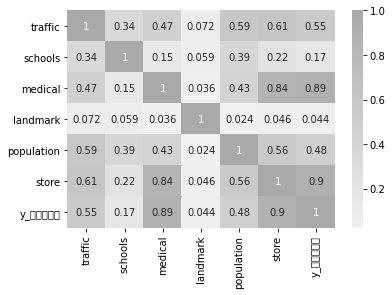

In [123]:
cmap = sns.light_palette("darkgray", as_cmap = True)  
sns.heatmap(vars.corr(), annot = True, cmap = cmap)
plt.show()
##다 양의 상관관계
#매출액에는 상가 수랑 병원수가 가장 높은 상관관계, 제일 낮은 관계는  랜드마크

# 다중선형회귀분석

In [43]:
x=final[['traffic', 'schools', 'medical','landmark', 'population','store']]
y=final[['y_매출액평균']]
x1= sm.add_constant(x, has_constant = "add")#상수항 추가(b0)
# OLS 검정
multi_reg_model= sm.OLS(y.astype(float), x1.astype(float))
fitted_multi_model = multi_reg_model.fit()
fitted_multi_model.summary()#R2는 0.862로 높으며 p-value에 따라 traffic, medical, store 변수가 유의함을 확인

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_매출액평균   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     2700.
Date:                Sun, 24 Jan 2021   Prob (F-statistic):               0.00
Time:                        01:11:12   Log-Likelihood:                -26508.
No. Observations:                2590   AIC:                         5.303e+04
Df Residuals:                    2583   BIC:                         5.307e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -134.7149    149.366     -0.902      0.367    -427.604     158.174
traffic      424.6602     89.161      4.763      0.000     249.826     599.495
schools     -525.5353    317.950     -1.653      0.098   -1148.999      97.928
medical     3095.6036     92.750     33.376      0.000    2913.731    3277.476
landmark     275.9711    897.824      0.307      0.759   -1484.557    2036.499
population    -0.2853      0.142     -2.015      0.044      -0.563      -0.008
store         84.9569      2.712     31.321      0.000      79.638      90.276
==============================================================================
Omnibus:                     4020.572   Durbin-Watson:                   1.689
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7957990.406
Skew:                           9.027   Prob(JB):                         0.00
Kurtosis:                     273.954   Cond. No.                     9.02e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
#store 변수가 하나 이상인 데이터들 추출
a =final['store'] > 0
exist= final[a]
exist.describe()

,traffic,schools,medical,landmark,population,store,y_매출액평균,y_분기별매출액평균_03,y_분기별매출액평균_06,y_분기별매출액평균_09,y_분기별매출액평균_12,y_연도별매출액평균_17,y_연도별매출액평균_18,y_연도별매출액평균_19,y_연도별매출액평균_20
count,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.00000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000
mean,1.990107,0.178071,0.826051,0.032152,848.609233,50.03380,7128.746963,6687.581410,7236.233512,7210.527205,7464.611981,5968.670857,7206.146331,7907.442086,7534.055785
std,2.631662,0.649661,3.887050,0.185591,1746.789598,149.77889,26055.939157,25126.947931,26126.351903,26166.517970,27143.590547,22288.281324,26490.979259,29122.593101,27149.706179
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,13.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,67.000000,5.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,0.000000,0.000000,0.000000,596.000000,29.00000,2979.533333,2462.500000,3048.500000,3124.750000,3196.333333,2365.750000,2922.750000,3274.500000,3184.000000
max,19.000000,10.000000,47.000000,2.000000,11734.000000,1807.00000,443717.800000,439361.250000,434969.500000,449432.000000,453572.000000,393261.000000,464547.750000,490119.000000,421352.000000


In [45]:
x=exist[['traffic', 'schools', 'medical','landmark', 'population','store']]
y=exist[['y_매출액평균']]#상가 수를 y로
x1= sm.add_constant(x, has_constant = "add")#상수항 추가(b0)
# OLS 검정
multi_reg_model= sm.OLS(y.astype(float), x1.astype(float))
fitted_multi_model = multi_reg_model.fit()
fitted_multi_model.summary()#R2는 0.857로 높으며 p-value에 따라 traffic, medical, store 변수가 유의함을 확인

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_매출액평균   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     1208.
Date:                Sun, 24 Jan 2021   Prob (F-statistic):               0.00
Time:                        01:11:14   Log-Likelihood:                -12873.
No. Observations:                1213   AIC:                         2.576e+04
Df Residuals:                    1206   BIC:                         2.580e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -282.1013    362.470     -0.778      0.437    -993.243     429.040
traffic      479.7009    143.842      3.335      0.001     197.492     761.910
schools     -529.6888    473.885     -1.118      0.264   -1459.419     400.041
medical     3108.1903    136.047     22.846      0.000    2841.274    3375.106
landmark     393.5346   1531.878      0.257      0.797   -2611.907    3398.976
population    -0.2903      0.210     -1.385      0.166      -0.702       0.121
store         84.2772      3.990     21.124      0.000      76.450      92.105
==============================================================================
Omnibus:                     1544.493   Durbin-Watson:                   1.686
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           795392.283
Skew:                           6.162   Prob(JB):                         0.00
Kurtosis:                     127.842   Cond. No.                     1.05e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
#VIF를 통한 다중공선성 판단
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x1.values, i) for i in range(x1.shape[1])]
vif["features"] = x1.columns
vif
#VIF는 variance inflation factor의 줄임말로,
#다중공선성을 확인할 때 쓰는 지표 중 하나며 보통 VIF가 10보다 크면 다중공선성이 있다고 판단한다. 
###다중공선성은 없다고 판단(다 10보다 작음)

,VIF Factor,features
0,1.637628,const
1,1.784628,traffic
2,1.180411,schools
3,3.482851,medical
4,1.006641,landmark
5,1.670876,population
6,4.447164,store


In [47]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns
vif

,VIF Factor,features
0,2.213734,traffic
1,1.269162,schools
2,3.631374,medical
3,1.024145,landmark
4,2.040894,population
5,4.931647,store


## 최적 모델 찾아내기

### 변수 선택법

In [49]:
def processSubset(X,y, feature_set):
            model = sm.OLS(y,X[list(feature_set)]) # Modeling
            regr = model.fit() # 모델 학습
            AIC = regr.aic # 모델의 AIC
            return {"model":regr, "AIC":AIC}  # 회귀모델과 AIC return
        
print(processSubset(X=x1, y=y, feature_set = vif["features"]))

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d970d30b8>, 'AIC': 25759.231051680556}


In [50]:
import time
import itertools
# getBest: k개의 변수의 조합 중 가장 낮은 AIC를 가지는 변수의 모델 선택 및 저장
def getBest(X,y,k):
    tic = time.time() # 시작시간
    results = [] # 결과 저장공간
    for combo in itertools.combinations(X.columns.difference(['const']), k): # 각 변수조합을 고려한 경우의 수
        combo=(list(combo)+['const'])
        
        results.append(processSubset(X,y,feature_set=combo)) 
    models = pd.DataFrame(results) 
    # 가장 낮은 AIC를 가지는 모델 선택 및 저장
    best_model = models.loc[models['AIC'].argmin()] # index
    toc = time.time() # 종료시간
    print("Processed ", models.shape[0], "models on", k, "predictors in", (toc - tic),
          "seconds.")
    return best_model


print(getBest(X=x1, y=y,k=2))

Processed  15 models on 2 predictors in 0.034531354904174805 seconds.
model    <statsmodels.regression.linear_model.Regressio...
AIC                                                25764.8
Name: 7, dtype: object


In [51]:
for combo in itertools.combinations(x1.columns.difference(['const']), 2):  # 상수항을 제거한 변수들을 k개로 조합
    print((list(combo)+['const']))  # 변수 조합에 각각 상수항 추가

['landmark', 'medical', 'const']
['landmark', 'population', 'const']
['landmark', 'schools', 'const']
['landmark', 'store', 'const']
['landmark', 'traffic', 'const']
['medical', 'population', 'const']
['medical', 'schools', 'const']
['medical', 'store', 'const']
['medical', 'traffic', 'const']
['population', 'schools', 'const']
['population', 'store', 'const']
['population', 'traffic', 'const']
['schools', 'store', 'const']
['schools', 'traffic', 'const']
['store', 'traffic', 'const']


In [52]:
# 변수 선택에 따른 학습시간과 저장
models = pd.DataFrame(columns=["AIC", "model"])
tic = time.time()
for i in range(1,4):  # 변수 조합을 1개부터 3개까지 iterate
    models.loc[i] = getBest(X=x1,y=y,k=i)  # 각 변수 조합 개수에서 가장 좋은 모델 선택
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  6 models on 1 predictors in 0.021839380264282227 seconds.
Processed  15 models on 2 predictors in 0.027950763702392578 seconds.
Processed  20 models on 3 predictors in 0.07032918930053711 seconds.
Total elapsed time: 0.13161611557006836 seconds.


In [53]:
models  # 변수 조합이 3개일 때 가장 낮은 AIC

,AIC,model
1,26196.259218,<statsmodels.regression.linear_model.Regressio...
2,25764.776455,<statsmodels.regression.linear_model.Regressio...
3,25758.905988,<statsmodels.regression.linear_model.Regressio...


In [54]:
models.loc[3, "model"].summary()  # 인덱스로 해당 모델에 접근

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_매출액평균   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     2412.
Date:                Sun, 24 Jan 2021   Prob (F-statistic):               0.00
Time:                        01:11:29   Log-Likelihood:                -12875.
No. Observations:                1213   AIC:                         2.576e+04
Df Residuals:                    1209   BIC:                         2.578e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
medical     3126.4267    135.831     23.017      0.000    2859.935    3392.918
store         82.7320      3.881     21.319      0.000      75.118      90.346
traffic      376.9719    134.376      2.805      0.005     113.336     640.608
const       -343.4539    358.222     -0.959      0.338   -1046.260     359.353
==============================================================================
Omnibus:                     1562.426   Durbin-Watson:                   1.690
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           826430.331
Skew:                           6.295   Prob(JB):                         0.00
Kurtosis:                     130.251   Cond. No.                         204.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 변수선택법==>최적모델: medical+ store+ traffic
R2=0.857  AIC:	2.576e+04

In [55]:
# 모든 변수들 모델링 한것과 비교 
print("full model Rsquared: ","{:.5f}".format(fitted_multi_model.rsquared))
print("full model AIC: ","{:.5f}".format(fitted_multi_model.aic))
print("full model MSE: ","{:.5f}".format(fitted_multi_model.mse_total))
print("selected model Rsquared: ","{:.5f}".format(models.loc[3, "model"].rsquared))
print("selected model AIC: ","{:.5f}".format(models.loc[3, "model"].aic))
print("selected model MSE: ","{:.5f}".format(models.loc[3, "model"].mse_total))
# 변수선택법을 사용한 모델보다 full 모델이 AIC가 높음

full model Rsquared:  0.85737
full model AIC:  25760.62198
full model MSE:  678911965.34814
selected model Rsquared:  0.85686
selected model AIC:  25758.90599
selected model MSE:  678911965.34814


## 전진선택법(step=1)

In [57]:
def forward(X, y, predictors):  # 선택되지 않은 변수 중 가장 AIC를 낮추는 변수를 선택하는 함수
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]  # 아직 선택되지 않은 남아있는 변수 리스트
    tic = time.time()
    results = []
    for p in remaining_predictors: 
        results.append(processSubset(X=X, y= y, feature_set=predictors+[p]+['const']))  # p번째 predictors로 모형 학습 후 결과 추가
    # 데이터프레임으로 변환
    models = pd.DataFrame(results)

    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()] # index
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic))
    print('Selected predictors:',best_model['model'].model.exog_names,' AIC:',best_model[0] )
    return best_model 

In [58]:
#### 전진선택법 모델

def forward_model(X,y):
    Fmodels = pd.DataFrame(columns=["AIC", "model"])
    tic = time.time()
    # 미리 정의된 데이터 변수
    predictors = []
    # 변수 1~10개 : 0~9 -> 1~10
    for i in range(1, len(X.columns.difference(['const'])) + 1):
        Forward_result = forward(X=X,y=y,predictors=predictors)  # 한 개의 변수를 추가했을 때 AIC가 가장 낮은 모델 반환
        if i > 1:
            if Forward_result['AIC'] > Fmodel_before:  # 변수를 추가했을 때 AIC가 감소하지 않으면
                break  # 전진선택법 중단
        Fmodels.loc[i] = Forward_result
        predictors = Fmodels.loc[i]["model"].model.exog_names
        Fmodel_before = Fmodels.loc[i]["AIC"]
        predictors = [ k for k in predictors if k != 'const']
    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")

    return(Fmodels['model'][len(Fmodels['model'])])

In [59]:
Forward_best_model = forward_model(X=x1, y= y)

Processed  6 models on 1 predictors in 0.01544952392578125
Selected predictors: ['store', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d9704c940>
Processed  5 models on 2 predictors in 0.01959371566772461
Selected predictors: ['store', 'medical', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d9704cef0>
Processed  4 models on 3 predictors in 0.009551763534545898
Selected predictors: ['store', 'medical', 'traffic', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d9704ca90>
Processed  3 models on 4 predictors in 0.005892515182495117
Selected predictors: ['store', 'medical', 'traffic', 'population', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d9704cba8>
Processed  2 models on 5 predictors in 0.02929401397705078
Selected predictors: ['store', 'medical', 'traffic', 'population', 'schools', 'const']  AIC: <stat

In [60]:
Forward_best_model.aic

25757.917373920198

In [61]:
Forward_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_매출액평균   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     1813.
Date:                Sun, 24 Jan 2021   Prob (F-statistic):               0.00
Time:                        01:11:30   Log-Likelihood:                -12874.
No. Observations:                1213   AIC:                         2.576e+04
Df Residuals:                    1208   BIC:                         2.578e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
store         84.3413      3.988     21.149      0.000      76.517      92.166
medical     3113.8045    135.917     22.910      0.000    2847.145    3380.464
traffic      456.6871    141.985      3.216      0.001     178.122     735.252
population    -0.3502      0.203     -1.726      0.085      -0.748       0.048
const       -274.9949    360.120     -0.764      0.445    -981.524     431.534
==============================================================================
Omnibus:                     1538.283   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           780745.913
Skew:                           6.118   Prob(JB):                         0.00
Kurtosis:                     126.684   Cond. No.                     2.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## ==>전진 선택법 최적모델: medical+ store+ traffic
R2은 0.857  AIC:	2.576e+04

## 후진선택법(step=1)

In [62]:
def backward(X,y,predictors):
    tic = time.time()
    results = []
    # 데이터 변수들이 미리정의된 predictors 조합 확인
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X=X, y= y,feature_set=list(combo)+['const']))
    models = pd.DataFrame(results)
    # 가장 낮은 AIC를 가진 모델을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors) - 1, "predictors in",
          (toc - tic))
    print('Selected predictors:',best_model['model'].model.exog_names,' AIC:',best_model[0] )
    return best_model

In [63]:
# 후진 소거법 모델
def backward_model(X, y):
    Bmodels = pd.DataFrame(columns=["AIC", "model"], index = range(1,len(X.columns)))
    tic = time.time()
    predictors = X.columns.difference(['const'])  # 모든 전체 변수를 넣은 채로 시작
    Bmodel_before = processSubset(X,y,predictors)['AIC']
    while (len(predictors) > 1):  # for문 대신 while문
        Backward_result = backward(X=x1, y= y, predictors = predictors)
        if Backward_result['AIC'] > Bmodel_before:   # AIC가 더이상 낮아지지 않으면
            break  # 후진제거법 중단
        Bmodels.loc[len(predictors) - 1] = Backward_result
        predictors = Bmodels.loc[len(predictors) - 1]["model"].model.exog_names
        Bmodel_before = Backward_result['AIC']
        predictors = [ k for k in predictors if k != 'const']

    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")
    return (Bmodels['model'].dropna().iloc[0])

In [64]:
Backward_best_model = backward_model(X=x1,y=y)

Processed  6 models on 5 predictors in 0.014825820922851562
Selected predictors: ['medical', 'population', 'schools', 'store', 'traffic', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d96fd72b0>
Processed  5 models on 4 predictors in 0.012397050857543945
Selected predictors: ['medical', 'population', 'store', 'traffic', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d96fd7940>
Processed  4 models on 3 predictors in 0.010399341583251953
Selected predictors: ['medical', 'store', 'traffic', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d96fd7e48>
Total elapsed time: 0.04718923568725586 seconds.


In [65]:
Backward_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_매출액평균   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     1813.
Date:                Sun, 24 Jan 2021   Prob (F-statistic):               0.00
Time:                        01:11:31   Log-Likelihood:                -12874.
No. Observations:                1213   AIC:                         2.576e+04
Df Residuals:                    1208   BIC:                         2.578e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
medical     3113.8045    135.917     22.910      0.000    2847.145    3380.464
population    -0.3502      0.203     -1.726      0.085      -0.748       0.048
store         84.3413      3.988     21.149      0.000      76.517      92.166
traffic      456.6871    141.985      3.216      0.001     178.122     735.252
const       -274.9949    360.120     -0.764      0.445    -981.524     431.534
==============================================================================
Omnibus:                     1538.283   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           780745.913
Skew:                           6.118   Prob(JB):                         0.00
Kurtosis:                     126.684   Cond. No.                     2.52e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.52e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## ==>전진 선택법 최적모델: medical+ store+ traffic
R2은 0.857  AIC:	2.576e+04

## stepwise 방법

In [66]:
def Stepwise_model(X,y):
    Stepmodels = pd.DataFrame(columns=["AIC", "model"])
    tic = time.time()
    predictors = []
    Smodel_before = processSubset(X,y,predictors+['const'])['AIC']
    # 변수 1~10개 : 0~9 -> 1~10
    for i in range(1, len(X.columns.difference(['const'])) + 1):
        Forward_result = forward(X=X, y=y, predictors=predictors)  # 전진선택법
        print('forward')
        Stepmodels.loc[i] = Forward_result 
        predictors = Stepmodels.loc[i]["model"].model.exog_names
        predictors = [ k for k in predictors if k != 'const']
        Backward_result = backward(X=X, y=y, predictors=predictors)  # 후진제거법
        if Backward_result['AIC']< Forward_result['AIC']:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]["model"].model.exog_names
            Smodel_before = Stepmodels.loc[i]["AIC"]
            predictors = [ k for k in predictors if k != 'const']
            print('backward')
        if Stepmodels.loc[i]['AIC']> Smodel_before:  # AIC가 감소하지 않으면
            break  # 단계선택법 중단
        else:
            Smodel_before = Stepmodels.loc[i]["AIC"]
    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")
    return (Stepmodels['model'][len(Stepmodels['model'])])

In [67]:
Stepwise_best_model=Stepwise_model(X=x1,y=y)

Processed  6 models on 1 predictors in 0.012499094009399414
Selected predictors: ['store', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d96fe4e80>
forward
Processed  1 models on 0 predictors in 0.008333444595336914
Selected predictors: ['const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d96fe4ba8>
Processed  5 models on 2 predictors in 0.01196432113647461
Selected predictors: ['store', 'medical', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d96fe4908>
forward
Processed  2 models on 1 predictors in 0.0073435306549072266
Selected predictors: ['store', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d96fe4be0>
Processed  4 models on 3 predictors in 0.03862428665161133
Selected predictors: ['store', 'medical', 'traffic', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7f9d9

In [68]:
Stepwise_best_model.aic

25757.917373920198

In [69]:
#Stepwise_best_model OLS 검정
x=final[['traffic', 'medical', 'population','store']]
y=final[['y_매출액평균']]
x1= sm.add_constant(x, has_constant = "add")#상수항 추가(b0)
# OLS 검정
multi_reg_model= sm.OLS(y.astype(float), x1.astype(float))
fitted_multi_model = multi_reg_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_매출액평균   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     4048.
Date:                Sun, 24 Jan 2021   Prob (F-statistic):               0.00
Time:                        01:11:33   Log-Likelihood:                -26510.
No. Observations:                2590   AIC:                         5.303e+04
Df Residuals:                    2585   BIC:                         5.306e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -131.9801    148.773     -0.887      0.375    -423.707     159.747
traffic      402.3263     87.862      4.579      0.000     230.040     574.612
medical     3100.8284     92.711     33.446      0.000    2919.034    3282.623
population    -0.3445      0.137     -2.513      0.012      -0.613      -0.076
store         85.0169      2.713     31.341      0.000      79.698      90.336
==============================================================================
Omnibus:                     4006.927   Durbin-Watson:                   1.687
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7817758.800
Skew:                           8.966   Prob(JB):                         0.00
Kurtosis:                     271.554   Cond. No.                     1.54e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## ==>Stepwise 최적모델: medical+ store+ traffic
R-squared:	0.862    AIC:	5.303e+04 
매출액은 다음변수들과 관계있다


# 로지스틱 다중 회귀분석

In [178]:
exist.columns

Index(['gid500', 'geometry', 'traffic', 'schools', 'medical', 'landmark',
       'population', 'store', 'y_매출액평균', 'y_분기별매출액평균_03', 'y_분기별매출액평균_06',
       'y_분기별매출액평균_09', 'y_분기별매출액평균_12', 'y_연도별매출액평균_17', 'y_연도별매출액평균_18',
       'y_연도별매출액평균_19', 'y_연도별매출액평균_20', 'bin_매출액평균'],
      dtype='object')

In [179]:
#매출액을 1과 0으로 값 부여
exist['bin_매출액평균']=0
exist['bin_매출액평균'] = np.where(exist['y_매출액평균'] > 7128.746963, 1,0)

In [180]:
exist.describe()

,traffic,schools,medical,landmark,population,store,y_매출액평균,y_분기별매출액평균_03,y_분기별매출액평균_06,y_분기별매출액평균_09,y_분기별매출액평균_12,y_연도별매출액평균_17,y_연도별매출액평균_18,y_연도별매출액평균_19,y_연도별매출액평균_20,bin_매출액평균
count,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.00000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000
mean,1.990107,0.178071,0.826051,0.032152,848.609233,50.03380,7128.746963,6687.581410,7236.233512,7210.527205,7464.611981,5968.670857,7206.146331,7907.442086,7534.055785,0.167354
std,2.631662,0.649661,3.887050,0.185591,1746.789598,149.77889,26055.939157,25126.947931,26126.351903,26166.517970,27143.590547,22288.281324,26490.979259,29122.593101,27149.706179,0.373445
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,13.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,67.000000,5.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,0.000000,0.000000,0.000000,596.000000,29.00000,2979.533333,2462.500000,3048.500000,3124.750000,3196.333333,2365.750000,2922.750000,3274.500000,3184.000000,0.000000
max,19.000000,10.000000,47.000000,2.000000,11734.000000,1807.00000,443717.800000,439361.250000,434969.500000,449432.000000,453572.000000,393261.000000,464547.750000,490119.000000,421352.000000,1.000000


In [73]:
#계산 확인
s0=exist.shape[0]
dummy = np.repeat(0,s0)
idx_1 = np.array(exist.y_매출액평균 > 7128.746963)
idx_2 = np.array(exist.y_매출액평균 <= 7128.746963)
dummy[idx_1] = 1  
dummy[idx_2] = 0  
np.mean(dummy)#ok!

0.16735366859027206

## 로지스틱 다중 회귀분석(y=매출액)

In [181]:
y=exist['bin_매출액평균']

In [184]:
from imblearn.over_sampling import SMOTE
#많은 데이터 확보를 위해 오버샘플링 적용
os = SMOTE(random_state=0)
#train, test set으로 나눠준다.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['bin_매출액평균'])

print("length of oversampled data is ",len(os_data_X))
print("Number of 0 in oversampled data",len(os_data_y[os_data_y['bin_매출액평균']==0]))
print("Number of 1",len(os_data_y[os_data_y['bin_매출액평균']==1]))
print("Proportion of 0 data in oversampled data is ",len(os_data_y[os_data_y['bin_매출액평균']==0])/len(os_data_X))
print("Proportion of 1 data in oversampled data is ",len(os_data_y[os_data_y['bin_매출액평균']==1])/len(os_data_X))

length of oversampled data is  1410
Number of 0 in oversampled data 705
Number of 1 705
Proportion of 0 data in oversampled data is  0.5
Proportion of 1 data in oversampled data is  0.5


### RFE (recursive feature elimination)
모든 변수를 우선 다 포함시키고 시작하며, 반복해서 학습을 진행하면서 중요도가 낮은 변수를 하나씩 제거하는 방식

In [186]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
rfe = RFE(log_reg, 6)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True]
[1 1 1 1 1 1]


/opt/app-root/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [189]:
cols=['traffic', 'schools', 'medical','landmark', 'population','store'] 
X=os_data_X[cols]
y=os_data_y['bin_매출액평균']

In [190]:
import statsmodels.api as sm
logit_mod=sm.Logit(y,X)
result=logit_mod.fit()
print(result.summary2())
##traffic, landmark, population, store 유의 

Optimization terminated successfully.
         Current function value: 0.433729
         Iterations 10
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.374      
Dependent Variable: bin_매출액평균        AIC:              1235.1154  
Date:               2021-01-24 04:30 BIC:              1266.6235  
No. Observations:   1410             Log-Likelihood:   -611.56    
Df Model:           5                LL-Null:          -977.34    
Df Residuals:       1404             LLR p-value:      7.3589e-156
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     10.0000                                       
-------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-------------------------------------------------------------------
traffic        -0.3420    0.0427  -8.0129  0.0000  -0.4256  -0.2583
schools        -0.1400    0.1040  -1.3465  0.178

### 모델 fit

In [191]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [1]:
y_pred = log_reg.predict(X_test)
print('test set에 대한 분류기 정확도: {:.2f}'.format(logreg.score(X_test, y_test)))

test set에 대한 분류기 정확도: 0.92


In [193]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[197  12]
 [ 23 191]]


## 핫스팟 데이터 연결

In [99]:
fin_df['sales_est_amt_total']=fin_df['sales_est_amt_201703']+fin_df['sales_est_amt_201706']+fin_df['sales_est_amt_201709']+fin_df['sales_est_amt_201712']+fin_df['sales_est_amt_201803']+fin_df['sales_est_amt_201806']+fin_df['sales_est_amt_201809']+fin_df['sales_est_amt_201812']+fin_df['sales_est_amt_201903']+fin_df['sales_est_amt_201906']+fin_df['sales_est_amt_201909']+fin_df['sales_est_amt_201912']+fin_df['sales_est_amt_202003']+fin_df['sales_est_amt_202006']+fin_df['sales_est_amt_202009']

df=fin_df

table = pd.read_csv('./input/grid행정동변환.csv')
table.columns = ['gid500','ADM_DR_CD','ADM_DR_NM']
df_dong = pd.merge(df,table,on='gid500')
df_dong.head(n=3)

,gid500,all_cnt,old_cnt,adult_cnt,young_cnt,건물연면적,ws_cnt,found_age_1,found_age_2,found_age_3,...,y_분기별매출액평균_06,y_분기별매출액평균_09,y_분기별매출액평균_12,y_연도별매출액평균_17,y_연도별매출액평균_18,y_연도별매출액평균_19,y_연도별매출액평균_20,sales_est_amt_total,ADM_DR_CD,ADM_DR_NM
0,다바66a99a,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,다바66a99b,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,다바66b99a,88.0,13.0,56.0,0.0,1781.97,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3119132.0,남사면


In [100]:
temp_dong = df_dong.copy()
temp_dong = temp_dong[['gid500','ADM_DR_NM','sales_est_amt_total','geometry']]
temp_dong = temp_dong.dropna()  # 행정동이 nan인 데이터 제거
temp_dong.head()

,gid500,ADM_DR_NM,sales_est_amt_total,geometry
2,다바66b99a,남사면,0.0,"POLYGON ((127.12306 37.08903, 127.12303 37.093..."
3,다바66b99b,남사면,0.0,"POLYGON ((127.12303 37.09353, 127.12301 37.098..."
4,다바67a99a,남사면,0.0,"POLYGON ((127.12868 37.08905, 127.12866 37.093..."
5,다바67a99b,남사면,0.0,"POLYGON ((127.12866 37.09355, 127.12864 37.098..."
7,다바67b99a,남사면,0.0,"POLYGON ((127.13431 37.08906, 127.13429 37.093..."


In [21]:
import pandas as pd
import geopandas as gpd

import random
import numpy as np
random.seed(10)
np.random.seed(100)

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

from pysal.lib  import weights
from esda.moran import Moran, Moran_Local

from splot.esda import moran_scatterplot,lisa_cluster, plot_local_autocorrelation

In [101]:
random.seed(10)
np.random.seed(100)

w = weights.contiguity.Queen.from_dataframe(temp_dong) # 가중치 행렬 생성
w.transform = 'r'
y = temp_dong['sales_est_amt_total'].values

In [102]:
#Spatial lag
temp_dong["w_sales"] = weights.lag_spatial(w, temp_dong["sales_est_amt_total"])
temp_dong.head()

,gid500,ADM_DR_NM,sales_est_amt_total,geometry,w_sales
2,다바66b99a,남사면,0.0,"POLYGON ((127.12306 37.08903, 127.12303 37.093...",0.0
3,다바66b99b,남사면,0.0,"POLYGON ((127.12303 37.09353, 127.12301 37.098...",0.0
4,다바67a99a,남사면,0.0,"POLYGON ((127.12868 37.08905, 127.12866 37.093...",0.0
5,다바67a99b,남사면,0.0,"POLYGON ((127.12866 37.09355, 127.12864 37.098...",0.0
7,다바67b99a,남사면,0.0,"POLYGON ((127.13431 37.08906, 127.13429 37.093...",7493.2


In [103]:
moran = Moran(y, w)
moran.I

0.2694674747593072

In [104]:
moran.p_sim

0.001

In [119]:
### Local Spatial Autocorrelation

In [96]:
### significant hot spot

In [105]:
(moran_loc.p_sim < 0.05).sum()

1407

In [106]:
sig = moran_loc.p_sim < 0.05
hotspot = sig * moran_loc.q==1
coldspot = sig * moran_loc.q==3
doughnut = sig * moran_loc.q==2
diamond = sig * moran_loc.q==4

In [107]:
spots = ['no_sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

In [111]:
spots = ['no_sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

In [112]:
spots_num = [0,1]
labels_num = [spots_num[i] for i in hotspot*1]

In [113]:
temp_dong['hotspot']=labels_num
temp_dong.head()

,gid500,ADM_DR_NM,sales_est_amt_total,geometry,w_sales,hotspot
2,다바66b99a,남사면,0.0,"POLYGON ((127.12306 37.08903, 127.12303 37.093...",0.0,0
3,다바66b99b,남사면,0.0,"POLYGON ((127.12303 37.09353, 127.12301 37.098...",0.0,0
4,다바67a99a,남사면,0.0,"POLYGON ((127.12868 37.08905, 127.12866 37.093...",0.0,0
5,다바67a99b,남사면,0.0,"POLYGON ((127.12866 37.09355, 127.12864 37.098...",0.0,0
7,다바67b99a,남사면,0.0,"POLYGON ((127.13431 37.08906, 127.13429 37.093...",7493.2,0


In [114]:
fin_df_hot = pd.merge(df,temp_dong[['gid500','hotspot']],on='gid500',how='left').fillna(0)
fin_gdf_hot = gpd.GeoDataFrame(fin_df_hot)
#fin_gdf_hot.to_file('fin_df_hot.geojson', driver='GeoJSON')
fin_gdf_hot.head(n=3)

,gid500,all_cnt,old_cnt,adult_cnt,young_cnt,건물연면적,ws_cnt,found_age_1,found_age_2,found_age_3,...,y_분기별매출액평균_03,y_분기별매출액평균_06,y_분기별매출액평균_09,y_분기별매출액평균_12,y_연도별매출액평균_17,y_연도별매출액평균_18,y_연도별매출액평균_19,y_연도별매출액평균_20,sales_est_amt_total,hotspot
0,다바66a99a,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,다바66a99b,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,다바66b99a,88.0,13.0,56.0,0.0,1781.97,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
print(len(fin_df_hot[fin_df_hot.hotspot==1]))

117


In [4]:
fin_df_hot.columns

Index(['gid500', 'all_cnt', 'old_cnt', 'adult_cnt', 'young_cnt', '건물연면적',
       'ws_cnt', 'found_age_1', 'found_age_2', 'found_age_3', 'found_age_4',
       'found_age_5', 'found_age_6', 'runout_cnt', 'smbiz_yn_cnt',
       'rpr_per_gender_m', 'rpr_per_gender_f', 'rpr_per_age_bin_10',
       'rpr_per_age_bin_20', 'rpr_per_age_bin_30to50',
       'rpr_per_age_bin_50over', 'sme_loan_cnt', 'sme_loan_y_1',
       'sme_loan_y_2', 'sme_loan_y_3', 'sme_loan_y_4', 'sme_loan_y_5',
       'sme_loan_y_6', 'sales_est_amt_201703', 'sales_est_amt_201706',
       'sales_est_amt_201709', 'sales_est_amt_201712', 'sales_est_amt_201803',
       'sales_est_amt_201806', 'sales_est_amt_201809', 'sales_est_amt_201812',
       'sales_est_amt_201903', 'sales_est_amt_201906', 'sales_est_amt_201909',
       'sales_est_amt_201912', 'sales_est_amt_202003', 'sales_est_amt_202006',
       'sales_est_amt_202009', 'age10_ratio', 'age20_ratio', 'age30_ratio',
       'age40_ratio', 'age50_ratio', 'age60_ratio', 'age70_

In [5]:
a =fin_df_hot['store'] > 0
exist_hot= fin_df_hot[a]
exist_hot.describe()

,all_cnt,old_cnt,adult_cnt,young_cnt,건물연면적,ws_cnt,found_age_1,found_age_2,found_age_3,found_age_4,...,y_분기별매출액평균_03,y_분기별매출액평균_06,y_분기별매출액평균_09,y_분기별매출액평균_12,y_연도별매출액평균_17,y_연도별매출액평균_18,y_연도별매출액평균_19,y_연도별매출액평균_20,sales_est_amt_total,hotspot
count,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,...,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1.213000e+03,1213.000000
mean,848.609233,114.469909,608.206925,113.825227,21510.481088,17.137675,0.609233,2.065952,2.023083,1.730420,...,6687.581410,7236.233512,7210.527205,7464.611981,5968.670857,7206.146331,7907.442086,7534.055785,1.069312e+05,0.096455
std,1746.789598,248.789757,1260.991127,267.255926,40714.175680,55.012540,2.298079,7.144820,7.252026,5.586615,...,25126.947931,26126.351903,26166.517970,27143.590547,22288.281324,26490.979259,29122.593101,27149.706179,3.908391e+05,0.295336
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,13.000000,0.000000,6.000000,0.000000,1810.760000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
50%,67.000000,8.000000,40.000000,0.000000,4465.710000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
75%,596.000000,77.000000,414.000000,55.000000,17989.890000,8.000000,0.000000,1.000000,1.000000,1.000000,...,2462.500000,3048.500000,3124.750000,3196.333333,2365.750000,2922.750000,3274.500000,3184.000000,4.469300e+04,0.000000
max,11734.000000,2135.000000,8472.000000,2182.000000,350462.070000,600.000000,30.000000,95.000000,128.000000,61.000000,...,439361.250000,434969.500000,449432.000000,453572.000000,393261.000000,464547.750000,490119.000000,421352.000000,6.655767e+06,1.000000


## 로지스틱 회귀분석(y=hotspot)

In [6]:
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [7]:
exist_hot.columns

Index(['gid500', 'all_cnt', 'old_cnt', 'adult_cnt', 'young_cnt', '건물연면적',
       'ws_cnt', 'found_age_1', 'found_age_2', 'found_age_3', 'found_age_4',
       'found_age_5', 'found_age_6', 'runout_cnt', 'smbiz_yn_cnt',
       'rpr_per_gender_m', 'rpr_per_gender_f', 'rpr_per_age_bin_10',
       'rpr_per_age_bin_20', 'rpr_per_age_bin_30to50',
       'rpr_per_age_bin_50over', 'sme_loan_cnt', 'sme_loan_y_1',
       'sme_loan_y_2', 'sme_loan_y_3', 'sme_loan_y_4', 'sme_loan_y_5',
       'sme_loan_y_6', 'sales_est_amt_201703', 'sales_est_amt_201706',
       'sales_est_amt_201709', 'sales_est_amt_201712', 'sales_est_amt_201803',
       'sales_est_amt_201806', 'sales_est_amt_201809', 'sales_est_amt_201812',
       'sales_est_amt_201903', 'sales_est_amt_201906', 'sales_est_amt_201909',
       'sales_est_amt_201912', 'sales_est_amt_202003', 'sales_est_amt_202006',
       'sales_est_amt_202009', 'age10_ratio', 'age20_ratio', 'age30_ratio',
       'age40_ratio', 'age50_ratio', 'age60_ratio', 'age70_

In [8]:
x=exist_hot[['traffic', 'schools', 'medical', 'landmark',
       'population', 'store']]
y=exist_hot['hotspot']

In [9]:
exist_hot['hotspot'].value_counts()

0.0    1096
1.0     117
Name: hotspot, dtype: int64

In [10]:
count_0 = len(exist_hot[exist_hot['hotspot']==0])
count_1 = len(exist_hot[exist_hot['hotspot']==1])
pct_of_1 = count_1/(count_0+count_1)
print("percentage of hotspot is", pct_of_1*100,"%")


percentage of hotspot is 9.64550700741962 %


In [11]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['hotspot'])

print("length of oversampled data is ",len(os_data_X))
print("Number of no hotspot in oversampled data",len(os_data_y[os_data_y['hotspot']==0]))
print("Number of hotspot",len(os_data_y[os_data_y['hotspot']==1]))
print("Proportion of no hotspot data in oversampled data is ",len(os_data_y[os_data_y['hotspot']==0])/len(os_data_X))
print("Proportion of hptspot data in oversampled data is ",len(os_data_y[os_data_y['hotspot']==1])/len(os_data_X))

length of oversampled data is  1746
Number of no hotspot in oversampled data 873
Number of hotspot 873
Proportion of no hotspot data in oversampled data is  0.5
Proportion of hptspot data in oversampled data is  0.5


In [12]:
x=exist_hot[['traffic', 'schools', 'medical', 'landmark',
       'population', 'store']]
y=exist_hot['hotspot']

In [13]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [14]:
data_final_vars=exist_hot.columns.values.tolist()
y=['hotspot']
X=['traffic', 'schools', 'medical', 'landmark','population', 'store']

logreg = LogisticRegression()   
rfe = RFE(logreg, 6)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True]
[1 1 1 1 1 1]


/opt/app-root/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [15]:
cols=['traffic', 'schools', 'medical', 'landmark','population', 'store']
X=os_data_X[cols]
y=os_data_y['hotspot']

In [16]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())##traffic, medical, landmark, population, store 변수가 유의하다.

Optimization terminated successfully.
         Current function value: 0.460469
         Iterations 8
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.336      
Dependent Variable: hotspot          AIC:              1619.9576  
Date:               2021-01-28 06:36 BIC:              1652.7480  
No. Observations:   1746             Log-Likelihood:   -803.98    
Df Model:           5                LL-Null:          -1210.2    
Df Residuals:       1740             LLR p-value:      2.2716e-173
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     8.0000                                        
-------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-------------------------------------------------------------------
traffic        -0.2333    0.0290  -8.0328  0.0000  -0.2902  -0.1764
schools        -0.1601    0.1119  -1.4307  0.1525

In [36]:
cols=['traffic', 'medical', 'landmark','population', 'store']
X=os_data_X[cols]
y=os_data_y['hotspot']

In [37]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.461109
         Iterations 8
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.335      
Dependent Variable: hotspot          AIC:              1620.1935  
Date:               2021-01-28 06:46 BIC:              1647.5189  
No. Observations:   1746             Log-Likelihood:   -805.10    
Df Model:           4                LL-Null:          -1210.2    
Df Residuals:       1741             LLR p-value:      4.5644e-174
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     8.0000                                        
-------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-------------------------------------------------------------------
traffic        -0.2409    0.0286  -8.4301  0.0000  -0.2969  -0.1849
medical        -0.2376    0.0395  -6.0137  0.0000

## 모델 Fit

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [39]:
y_pred = logreg.predict(X_test)
print('test set에 대한 분류기 정확도: {:.2f}'.format(logreg.score(X_test, y_test)))

test set에 대한 분류기 정확도: 0.91


In [40]:
#confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[254  22]
 [ 27 221]]


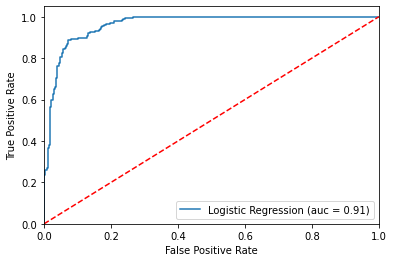

In [41]:
##ROC Curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (auc = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('Log_ROC')
plt.show()

##로지스틱(핫스팟) : traffic, medical, landmark, population, store LLR p-value: 2.2716e-173, AIC: 1619.9576, 예측력: 0.91


In [42]:
np.exp(result.params)#오즈비

traffic       0.785905
medical       0.788496
landmark      0.041013
population    1.000306
store         1.015110
dtype: float64

In [44]:
1/np.exp(result.params)#오즈비 역수

traffic        1.272419
medical        1.268238
landmark      24.382778
population     0.999694
store          0.985115
dtype: float64

오즈비는 1을 기준으로 종속변수 y에 미치는 영향을 파악할 수 있으며, 1에서 멀리 떨어질수록 강한 관계를 의미한다.
위의 변수 중에서는 landmark의 오즈비는 0.04(역수는 24.38)로 1에서 가장 멀리 떨어져있다. 따라서 핫스팟에는 landmark가 가장 큰 영향을주는 강한 관계임을 알 수 있다.
그 외에도 traffic, medical이 영향을 주지만 그 정도가 크지 않음을 해석할 수 있고, population과 store은 1에 매우 가까워 별다른 영향을 주지 않았음을 알 수 있다.



____________________________________________________________________________________________________________________________
매출액평균을 종속변수 y로 설정한 로지스틱 회귀분석도 매우 유의한 결과가 나왔다. 하지만 핫스팟은 매출을 기준으로 군집화된 값이고 매출액 평균은 표준편차나 특수한 값을 반영하기 어렵기때문에 핫스팟을 y로 설정한 로지스틱 회귀분석이 더 분석에 적합하다.